# NFL Baseline

# import libraries

In [1]:
# general
import os
import gc
import pickle
import glob
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import time
import math

import sys
sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
import timm


# deep learning
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import StratifiedKFold

# loss metrics
from sklearn.metrics import matthews_corrcoef, confusion_matrix

import mlflow
# import wandb
# warningの表示方法の設定
import warnings
warnings.filterwarnings("ignore")

# Set Configurations

In [2]:
CFG = {
        "kaggle" : False,
        "DEBUG" : False,
        # model config
        "model_name" : "tf_efficientnet_b0",
        "out_features" : 1,
        "inp_channels": 3*5,
        "pretrained" : True,

        # learning config
        "n_epoch" : 10,
        "lr" : 1e-4,
        "T_max" : 10,
        "min_lr" : 1e-8,
        "weight_decay" : 1e-6,

        # etc
        "print_freq" : 100,
        "random_seed" : 21,

        # data config    
        "img_size" : (224, 224),
        "batch_size" : 16,
        "shuffle" : True, 
        "num_workers" : 0,
        "masksize_helmet_ratio" : 4, # helmetサイズにこの係数をかけたサイズだけ色を残して後は黒塗りする
        "TRAIN_VIDEO_NUM" : 2,
        "VALID_VIDEO_NUM" : 1,
        "sample_num" : -1,
        "ONLY_GROUND" : False,
        "ONLY_PLAYERS" :  True,
        "USE_ONLY_HELMET_AVAIL" : True,

        "EXP_CATEGORY" : "make_baseline",
        "EXP_NAME" : "baseline018P_D",
}

if CFG["DEBUG"]:
    CFG["EXP_NAME"] = "DEBUG"
    CFG["n_epoch"] = 1
    CFG["sample_num"] = 500

if CFG["kaggle"]:
    CFG["INPUT_DIR"] = "/kaggle/input/"
    CFG["OUTPUT_DIR"] = "/kaggle/working"
    CFG["TRAIN_HELMET_CSV"] = os.path.join(CFG["INPUT_DIR"], "nfl-player-contact-detection", "train_baseline_helmets.csv")
    CFG["TRAIN_TRACKING_CSV"] = os.path.join(CFG["INPUT_DIR"], "nfl-player-contact-detection", "train_player_tracking.csv")
    CFG["TRAIN_VIDEO_META_CSV"] = os.path.join(CFG["INPUT_DIR"], "nfl-player-contact-detection", "train_video_metadata.csv")
    CFG["TRAIN_LABEL_CSV"] = os.path.join(CFG["INPUT_DIR"], "nfl-player-contact-detection", "train_labels.csv")
    CFG["TARGET_CSV"] = os.path.join(CFG["INPUT_DIR"], "target_fillna0.csv")
    CFG["TRAIN_IMG_DIR"] = os.path.join(CFG["INPUT_DIR"], "nfl-baseline-saveframes")
    CFG["MODEL_DIR"] = os.path.join(CFG["OUTPUT_DIR"], "model")
else:
    CFG["INPUT_DIR"] = "/workspace/input"
    CFG["OUTPUT_DIR"] = "/workspace/output"
    CFG["TRAIN_HELMET_CSV"] = os.path.join(CFG["INPUT_DIR"], "train_baseline_helmets.csv")
    CFG["TRAIN_TRACKING_CSV"] = os.path.join(CFG["INPUT_DIR"], "train_player_tracking.csv")
    CFG["TRAIN_VIDEO_META_CSV"] = os.path.join(CFG["INPUT_DIR"], "train_video_metadata.csv")
    CFG["TRAIN_LABEL_CSV"] = os.path.join(CFG["INPUT_DIR"], "train_labels.csv")
    CFG["TARGET_CSV"] = os.path.join(CFG["INPUT_DIR"], "target_fillna0_3.csv")
    CFG["TRAIN_IMG_DIR"] = os.path.join(CFG["INPUT_DIR"], "train_frames")
    CFG["MODEL_DIR"] = os.path.join(CFG["OUTPUT_DIR"], CFG["EXP_NAME"] ,"model")
    
if not CFG["kaggle"] and not CFG["DEBUG"]:
    os.mkdir(os.path.join(CFG["OUTPUT_DIR"], CFG["EXP_NAME"]))
    os.mkdir(CFG["MODEL_DIR"])


In [3]:
if CFG["kaggle"]:
    WANDB_CONFIG = {'competition': 'NFL', '_wandb_kernel': 'taro'}
    # Secrets
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("wandb")

    !wandb login $secret_value_0
    #! TODO : logger settings
else:
    mlflow.set_tracking_uri("/workspace/mlruns")
    experiment = mlflow.get_experiment_by_name(CFG["EXP_CATEGORY"])
    if experiment is None:  # 当該Experiment存在しないとき、新たに作成
        experiment_id = mlflow.create_experiment(name=CFG["EXP_CATEGORY"])
    else: # 当該Experiment存在するとき、IDを取得
        experiment_id = experiment.experiment_id

# Utils

In [4]:
def logging_metrics_epoch(fold, epoch, train_loss_avg, valid_loss_avg, score, threshold, tn_best, fp_best, fn_best, tp_best):
    if CFG["kaggle"]:
            pass # set wandb logger
    else:
        mlflow.log_metric(f"fold{fold} train loss avg", train_loss_avg, step=epoch)
        mlflow.log_metric(f"fold{fold} valid loss avg", valid_loss_avg, step=epoch)
        mlflow.log_metric(f"fold{fold} score", score, step=epoch)
        mlflow.log_metric(f"fold{fold} score threshold", threshold, step=epoch)
        mlflow.log_metric(f"fold{fold} tn", tn_best, step=epoch)
        mlflow.log_metric(f"fold{fold} fp", fp_best, step=epoch)
        mlflow.log_metric(f"fold{fold} fn", fn_best, step=epoch)
        mlflow.log_metric(f"fold{fold} tp", tp_best, step=epoch)

In [5]:
def seed_everything(seed=CFG["random_seed"]):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed%(2**32-1))
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
    torch.backends.cudnn.benchmark = False
seed_everything()

# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [6]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Scoring Utils

In [7]:
def score_targetlong_concat(df_, long_df_):
    long_df_["pred"] = 0
    long_df_.iloc[-1]["pred"] = 1

    for threshold in [0.1, 0.5, 0.9]:
        scoring_df = pd.concat([long_df_[["contact_id", "contact", "pred"]], df_[["contact_id", "contact", "pred"]]], axis=0)
        scoring_df["pred"] = (scoring_df["pred"].values > threshold).astype(int)
        score = matthews_corrcoef(scoring_df["contact"].values, scoring_df["pred"].values)
        cm = confusion_matrix(scoring_df["contact"].values, scoring_df["pred"].values)
        tn, fp, fn, tp = cm.flatten()
        print(f"score = {score}, thr={threshold}")
        print(f"tn={tn}, fp={fp}, fn={fn}, tp={tp}")
        mlflow.log_metric("oof target concat score", score, step=int(threshold*10))

In [8]:
def ground_players_score_log(df_, threshold = 0.5):
    scoring_df = df_.copy()
    concat_df = scoring_df["contact_id"].str.split("_", expand=True) 
    concat_df.columns=["game_key", "play_id", "step", "nfl_player_id_1", "nfl_player_id_2"]
    concat_df["game_play"] = concat_df['game_key'].str.cat(concat_df['play_id'].astype(str), sep='_')
    concat_df["step"] = concat_df["step"].map(int)
    scoring_df = pd.concat([scoring_df, concat_df], axis=1)

    scoring_df = scoring_df[scoring_df["nfl_player_id_2"]=="G"]
    scoring_df["pred"] = (scoring_df["pred"].values > threshold).astype(int)
    score = matthews_corrcoef(scoring_df["contact"].values, scoring_df["pred"].values)
    cm = confusion_matrix(scoring_df["contact"].values, scoring_df["pred"].values)
    tn, fp, fn, tp = cm.flatten()
    print("-- ground score --")
    print(f"score = {score}, thr={threshold}")
    print(f"tn={tn}, fp={fp}, fn={fn}, tp={tp}")
    mlflow.log_metric("oof ground score", score)


    scoring_df = df_.copy()
    concat_df = scoring_df["contact_id"].str.split("_", expand=True) 
    concat_df.columns=["game_key", "play_id", "step", "nfl_player_id_1", "nfl_player_id_2"]
    concat_df["game_play"] = concat_df['game_key'].str.cat(concat_df['play_id'].astype(str), sep='_')
    concat_df["step"] = concat_df["step"].map(int)
    scoring_df = pd.concat([scoring_df, concat_df], axis=1)

    scoring_df = scoring_df[scoring_df["nfl_player_id_2"]!="G"]
    scoring_df["pred"] = (scoring_df["pred"].values > threshold).astype(int)
    score = matthews_corrcoef(scoring_df["contact"].values, scoring_df["pred"].values)
    cm = confusion_matrix(scoring_df["contact"].values, scoring_df["pred"].values)
    tn, fp, fn, tp = cm.flatten()
    print("-- players score --")
    print(f"score = {score}, thr={threshold}")
    print(f"tn={tn}, fp={fp}, fn={fn}, tp={tp}")
    mlflow.log_metric("oof players score", score)

## Dataset Utils

In [9]:
def set_inimg_window(crop_pos, mask_size, img_size=(720, 1280)):#crop_pos = [left, top, right, bot]
    # print("[set_in_window] crop_pos", crop_pos)
    # print("[set_in_window] mask_size",mask_size)
    # print("[set_in_window] img_size",img_size)
    if mask_size[1] >= img_size[0]:
        top, bot = 0, img_size[1]
    else:
        top=(crop_pos[1] + crop_pos[3])//2 - mask_size[1]//2
        bot=(crop_pos[1] + crop_pos[3])//2 + mask_size[1]//2
        if top < 0:
            bot = bot - top
            top = 0
        elif bot > img_size[0]:
            top = top - (bot-img_size[0])
            bot = img_size[0]

    if mask_size[0] >= img_size[1]:
        left, right = 0, img_size[1]
    else:
        left = (crop_pos[0] + crop_pos[2])//2 - mask_size[0]//2
        right = (crop_pos[0] + crop_pos[2])//2 + mask_size[0]//2
        if left < 0:
            right = right - left
            left = 0
        elif right > img_size[1]:
            left = left - (right - img_size[1])
            right = img_size[1]
    crop_area = np.array([left, top, right, bot]).astype(np.int)
    return crop_area

In [10]:
def get_crop_area(p1_helmet, p2_helmet, input_size=(720, 1280)):#helmet[left, width, top, height]
    if (p1_helmet[1]==0 and p1_helmet[3]==0) and (p2_helmet[1]==0 and p2_helmet[3]==0):
        crop_area = [0, 0, input_size[1], input_size[0]]
        # print("bose player's helmet is not detected.")
        return crop_area
    elif (p2_helmet[1]==0 and p2_helmet[3]==0) and (p1_helmet[1] != 0 and p1_helmet[3]!=0):
        # print("p1 detected.")
        crop_x_center, crop_y_center = p1_helmet[0] + (p1_helmet[1])//2, p1_helmet[2] + (p1_helmet[3])//2
        helmet_base_size = (p1_helmet[1] + p1_helmet[3])*0.5*CFG["masksize_helmet_ratio"]*4
        output_size = [helmet_base_size, helmet_base_size]
    elif (p1_helmet[1]==0 and p1_helmet[3]==0) and (p2_helmet[1]!=0 and p2_helmet[3]!=0):
        # print("p2 detected.")
        crop_x_center, crop_y_center = p2_helmet[0] + (p2_helmet[1])//2, p2_helmet[2] + (p2_helmet[3])//2
        helmet_base_size = (p2_helmet[1] + p2_helmet[3])*0.5*CFG["masksize_helmet_ratio"]*4
        output_size = [helmet_base_size, helmet_base_size]
    else:
    #     print("p1 and p2 detected.")
        p1_x_center, p1_y_center = p1_helmet[0] + (p1_helmet[1])//2, p1_helmet[2] + (p1_helmet[3])//2
        p2_x_center, p2_y_center = p2_helmet[0] + (p2_helmet[1])//2, p2_helmet[2] + (p2_helmet[3])//2
        crop_x_center, crop_y_center = (p1_x_center + p2_x_center)//2, (p1_y_center + p2_y_center)//2
        helmet_base_size = (abs(p1_x_center - p2_x_center) + abs(p1_y_center - p2_y_center))*0.5 \
                            + ((p1_helmet[1] + p2_helmet[1])*0.5 + (p1_helmet[3] + p2_helmet[3])*0.5)*0.5*CFG["masksize_helmet_ratio"]*2
        output_size = [helmet_base_size, helmet_base_size]
    
    # print("crop center", crop_x_center, crop_y_center)
    crop_left = crop_x_center - output_size[1]//2
    crop_top = crop_y_center - output_size[0]//2
    crop_right = crop_x_center + output_size[1]//2
    crop_bot = crop_y_center + output_size[0]//2
    crop_area = [crop_left, crop_top, crop_right, crop_bot]
    crop_area = set_inimg_window(crop_area, output_size)
    return crop_area

In [11]:
def get_playermasked_img(img, helmet_pos, img_size=(720, 1280, 3)):#helmet pos = [left, width, top, height]
    if helmet_pos[1] == 0 and helmet_pos[3] == 0:
        mask = np.ones_like(img)
        return mask
    mask_size=(helmet_pos[1]+helmet_pos[3])*0.5*CFG["masksize_helmet_ratio"]# helmetの大きさによってplayerの範囲も変更
    helmet_area = [helmet_pos[0], helmet_pos[2], helmet_pos[0]+helmet_pos[1], helmet_pos[2]+helmet_pos[3]]#[left, top, right, bot]
    player_area = set_inimg_window(helmet_area, (mask_size,mask_size))
    mask = np.zeros(img_size, dtype=np.float)
    cv2.rectangle(mask, [player_area[0], player_area[1]], [player_area[2], player_area[3]], (255, 255, 255), -1)
    mask = np.clip(mask, 0, 1).astype(np.float)
    return mask

# Load Data

In [12]:
target_df = pd.read_csv(CFG["TARGET_CSV"])
# target_game_plays = target_df["game_play"].unique()[:50]
train_game_plays = target_df["game_play"].unique()[:CFG["TRAIN_VIDEO_NUM"]]
valid_game_plays = target_df["game_play"].unique()[CFG["TRAIN_VIDEO_NUM"]: CFG["TRAIN_VIDEO_NUM"]+CFG["VALID_VIDEO_NUM"]]

target_game_plays = list(set(train_game_plays) | set(valid_game_plays))
CFG["train_game_plays"] = list(train_game_plays)
CFG["valid_game_plays"] = list(valid_game_plays)
target_df = target_df[target_df["game_play"].isin(target_game_plays)]

if CFG["ONLY_GROUND"]:
    target_df = target_df[target_df["nfl_player_id_2"]=="G"]
    if CFG["USE_ONLY_HELMET_AVAIL"]:
        target_df = target_df[target_df["E_width_1"]!=0]

if CFG["ONLY_PLAYERS"]:
    target_df = target_df[target_df["nfl_player_id_2"]!="G"]
    if CFG["USE_ONLY_HELMET_AVAIL"]:
        target_df = target_df[target_df["E_width_1"]!=0]
        target_df = target_df[target_df["E_width_2"]!=0]


if CFG["DEBUG"]:
    target_df = target_df.sample(CFG["sample_num"])
elif CFG["sample_num"] != -1:
    target_df = target_df.sample(CFG["sample_num"])
    
print(len(target_df))
display(target_df["contact"].value_counts())

5847


0    5033
1     814
Name: contact, dtype: int64

In [13]:
display(target_df.head())
print(target_df.columns)

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,frame,game_frame,game_frame_player_1,...,E_top_2,E_height_2,S_left_1,S_width_1,S_top_1,S_height_1,S_left_2,S_width_2,S_top_2,S_height_2
0,58168_003392_0_38590_41944,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,41944,0,298,58168_003392_298,58168_003392_298_38590,...,291.0,34.0,468.0,13.0,372.0,18.0,511.0,13.0,415.0,15.0
1,58168_003392_0_38590_47944,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,47944,0,298,58168_003392_298,58168_003392_298_38590,...,315.0,17.0,468.0,13.0,372.0,18.0,530.0,14.0,351.0,17.0
2,58168_003392_0_38590_44822,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,44822,0,298,58168_003392_298,58168_003392_298_38590,...,254.0,33.0,468.0,13.0,372.0,18.0,427.0,14.0,384.0,19.0
3,58168_003392_0_38590_39947,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,39947,0,298,58168_003392_298,58168_003392_298_38590,...,281.0,34.0,468.0,13.0,372.0,18.0,473.0,15.0,342.0,18.0
4,58168_003392_0_38590_42565,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,42565,0,298,58168_003392_298,58168_003392_298_38590,...,313.0,19.0,468.0,13.0,372.0,18.0,478.0,15.0,400.0,18.0


Index(['contact_id', 'game_play', 'datetime', 'step', 'nfl_player_id_1',
       'nfl_player_id_2', 'contact', 'frame', 'game_frame',
       'game_frame_player_1', 'game_frame_player_2', 'x_position_1',
       'y_position_1', 'x_position_2', 'y_position_2', 'players_dis',
       'E_left_1', 'E_width_1', 'E_top_1', 'E_height_1', 'E_left_2',
       'E_width_2', 'E_top_2', 'E_height_2', 'S_left_1', 'S_width_1',
       'S_top_1', 'S_height_1', 'S_left_2', 'S_width_2', 'S_top_2',
       'S_height_2'],
      dtype='object')


# Dataset

In [14]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

In [15]:
class NFLDataset(Dataset):
    def __init__(self, target_df, transform=None):
        self.target_df = target_df
        self.transform = transform

    def __len__(self):
        return len(self.target_df)

    def __getitem__(self, idx):
        target_info = self.target_df.iloc[idx]
        target = target_info.contact
        # read frame image
        game_play = target_info.game_play
        frame = target_info.frame
        input_img = None
        load_frame_list = [-6, -3, 0, 3, 6]
        for load_idx in range(CFG["inp_channels"]//3):
            load_frame = frame + load_frame_list[load_idx]
            file_id = f"{game_play}_Endzone_{load_frame:04}.jpg"
            # file_id = f"{game_play}_Endzone_{frame:04}.jpg"
            filename = os.path.join(CFG["TRAIN_IMG_DIR"], file_id)
            img = cv2.imread(filename)
            if img is None:
                img = np.zeros((224, 224, 3))
                img = np.transpose(img, (2, 0, 1)).astype(np.float32)
                img = torch.tensor(img, dtype=torch.float32)
                print(filename)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # player highlight mask
                player1 = target_info.nfl_player_id_1
                player2 = target_info.nfl_player_id_2
                p1_helmet = np.array([target_info.E_left_1, target_info.E_width_1,
                                    target_info.E_top_1, target_info.E_height_1]).astype(np.int)#[left, width, top, height]
                p2_helmet = np.array([target_info.E_left_2, target_info.E_width_2,
                                    target_info.E_top_2, target_info.E_height_2]).astype(np.int)
                mask1 = get_playermasked_img(img, p1_helmet)
                mask2 = get_playermasked_img(img, p2_helmet)
                mask = np.clip(mask1 + mask2, 0, 1).astype(np.float32)
                img = (mask*img).astype(np.float32)
                # crop players area
                crop_area = get_crop_area(p1_helmet, p2_helmet)# crop_area=[left, top, right, bot]
                img = img[crop_area[1]:crop_area[3], crop_area[0]:crop_area[2], :]
                img = cv2.resize(img, dsize=CFG["img_size"])
                img = (img / 255.).astype(np.float32) # convert to 0-1
                if self.transform is not None:
                    img = self.transform(image=img)["image"]
                else:
                    img = np.transpose(img, (2, 0, 1)).astype(np.float)
            if input_img is None:
                input_img = img
            else:
                input_img = np.concatenate([input_img, img], axis=0)
        target = torch.tensor(target, dtype=torch.float32)
        
        return input_img, target

In [16]:
# train_dataset = NFLDataset(target_df, transform=train_transform)
# show_img_num = 4
# train_loader = DataLoader(
#     train_dataset,
#     batch_size = show_img_num,
#     shuffle = True,
#     num_workers = CFG["num_workers"],
#     pin_memory = True
# )

# for batch_idx, (images, targets) in enumerate(train_loader):
#     for idx in range(show_img_num):
#         img = images[idx].numpy()
#         img = np.transpose(img, (1, 2, 0)).astype(np.float)
#         print(img.shape)
#         fig = plt.figure(figsize=(12, 25))
#         for frame in range(CFG["inp_channels"]//3):
#             frame_img = img[:,:, frame*3:(frame+1)*3]*255
#             fig.add_subplot(1, CFG["inp_channels"]//3, frame+1)
#             plt.imshow(frame_img)
#         plt.title(targets[idx].numpy())
#         plt.show()
#     break
# del train_loader, train_dataset

# positive_df = target_df[target_df["contact"]==1]
# train_dataset = NFLDataset(positive_df, transform=train_transform)
# show_img_num = 4
# train_loader = DataLoader(
#     train_dataset,
#     batch_size = show_img_num,
#     shuffle = True,
#     num_workers = CFG["num_workers"],
#     pin_memory = True
# )


# for batch_idx, (images, targets) in enumerate(train_loader):
#     for idx in range(show_img_num):
#         img = images[idx].numpy()
#         img = np.transpose(img, (1, 2, 0)).astype(np.float)
#         print(img.shape)
#         fig = plt.figure(figsize=(12, 25))
#         for frame in range(CFG["inp_channels"]//3):
#             frame_img = img[:,:, frame*3:(frame+1)*3]*255
#             fig.add_subplot(1, CFG["inp_channels"]//3, frame+1)
#             plt.imshow(frame_img)
#         plt.title(targets[idx].numpy())
#         plt.show()
#     break
# del train_loader, train_dataset

# raise Exception()

# Model

In [17]:
# without meta
class NFLNet(nn.Module):
    def __init__(
        self,
        model_name = CFG["model_name"],
        out_features = CFG["out_features"],
        inp_channels= CFG["inp_channels"],
        pretrained = CFG["pretrained"]
    ):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=inp_channels, num_classes = out_features)
    
    def forward(self, image):
        output = self.model(image)
        return output

# train fn

In [18]:
def train_fn(train_loader, model, criterion, epoch ,optimizer, scheduler):
    model.train()
    batch_time = AverageMeter()
    losses = AverageMeter()
    start = end = time.time()
    for batch_idx, (images, targets) in enumerate(train_loader):
        images = images.to(device, non_blocking = True).float()
        targets = targets.to(device, non_blocking = True).float().view(-1, 1)                
        preds = model(images)
        
        loss = criterion(preds, targets)
        losses.update(loss.item(), CFG["batch_size"]) 
        targets = targets.detach().cpu().numpy().ravel().tolist()
        preds = torch.sigmoid(preds).detach().cpu().numpy().ravel().tolist()

        loss.backward() # パラメータの勾配を計算
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
                
        batch_time.update(time.time() - end)
        end = time.time()
        if batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(train_loader)-1):
            print('\t Epoch: [{0}][{1}/{2}] '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                        epoch, batch_idx, len(train_loader), batch_time=batch_time, loss=losses,
                        remain=timeSince(start, float(batch_idx+1)/len(train_loader)),
            ))
        del preds, images, targets
    gc.collect()
    torch.cuda.empty_cache()
    return losses.avg

# valid fn

In [19]:
def valid_fn(model, valid_loader, criterion):
    model.eval()# モデルを検証モードに設定
    test_targets = []
    test_preds = []

    batch_time = AverageMeter()
    losses = AverageMeter()
    start = end = time.time()
    for batch_idx, (images, targets) in enumerate(valid_loader):
        images = images.to(device, non_blocking = True).float()
        targets = targets.to(device, non_blocking = True).float().view(-1, 1)
        with torch.no_grad():
            preds = model(images)
            loss = criterion(preds, targets)
        losses.update(loss.item(), CFG["batch_size"])
        batch_time.update(time.time() - end)

        targets = targets.detach().cpu().numpy().ravel().tolist()
        preds = torch.sigmoid(preds).detach().cpu().numpy().ravel().tolist()

        test_preds.extend(preds)
        test_targets.extend(targets)
        # score = matthews_corrcoef(preds, targets)
        if batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(valid_loader)-1):
            print('\t EVAL: [{0}/{1}] '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                    batch_idx, len(valid_loader), batch_time=batch_time, loss=losses,
                    remain=timeSince(start, float(batch_idx+1)/len(valid_loader)),
                ))
        del preds, images, targets
        gc.collect()
        torch.cuda.empty_cache()
    test_preds = np.array(test_preds)
    test_targets = np.array(test_targets)
    return test_targets, test_preds, losses.avg

# Train loop

In [20]:
def training_loop(target_df):
    
    # set model & learning fn
    model = NFLNet()
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"], amsgrad=False)
    scheduler = CosineAnnealingLR(optimizer, T_max=CFG["T_max"], eta_min=CFG["min_lr"], last_epoch=-1)

    oof_df = pd.DataFrame()

    fold = 0
    print(f'fold {fold} training start.')        
    # separate train/valid data 
    train_df = target_df[target_df["game_play"].isin(train_game_plays)]
    valid_df = target_df[target_df["game_play"].isin(valid_game_plays)]
    # train_dataset = NFLDataset(train_df)
    # valid_dataset = NFLDataset(valid_df)
    train_dataset = NFLDataset(train_df, train_transform)
    valid_dataset = NFLDataset(valid_df, valid_transform)
    train_loader = DataLoader(train_dataset,batch_size=CFG["batch_size"], shuffle = CFG["shuffle"],
                                num_workers = CFG["num_workers"], pin_memory = True)
    valid_loader = DataLoader(valid_dataset,batch_size=CFG["batch_size"], shuffle = CFG["shuffle"],
                                num_workers = CFG["num_workers"], pin_memory = True)

    # training
    best_score = -np.inf
    start_time = end = time.time()
    for epoch in range(1, CFG["n_epoch"] + 1):
        print(f'\t === epoch: {epoch}: training ===')
        train_loss_avg = train_fn(train_loader, model, criterion, epoch ,optimizer, scheduler)
        valid_targets, valid_preds, valid_loss_avg = valid_fn(model, valid_loader, criterion)

        valid_score = -np.inf
        valid_threshold = 0
        tn_best, fp_best, fn_best, tp_best = 0, 0, 0, 0
        for idx in range(1, 10, 1):
            thr = idx*0.1
            valid_targets = (np.array(valid_targets) > thr).astype(np.int32)
            valid_binary_preds = (np.array(valid_preds) > thr).astype(np.int32)
            score_tmp = matthews_corrcoef(valid_targets, valid_binary_preds)
            cm = confusion_matrix(valid_targets, valid_binary_preds)
            tn, fp, fn, tp = cm.flatten()
            if score_tmp > valid_score:
                valid_score = score_tmp 
                valid_threshold = thr
                tn_best, fp_best, fn_best, tp_best = tn, fp, fn, tp
        elapsed = time.time() - start_time
        print(f'\t epoch:{epoch}, avg train loss:{train_loss_avg:.4f}, avg valid loss:{valid_loss_avg:.4f}, score:{valid_score:.4f}(th={valid_threshold}) ::: time:{elapsed:.2f}s')
        scheduler.step()
        # validationスコアがbestを更新したらモデルを保存する
        if valid_score > best_score:
            best_score = valid_score
            model_name = CFG["model_name"]
            torch.save(model.state_dict(), f'{CFG["MODEL_DIR"]}/{model_name}_fold{fold}.pth')
            print(f'\t Epoch {epoch} - Save Best Score: {best_score:.4f}. Model is saved.')
            contact_id = valid_df["contact_id"].values
            _oof_df = pd.DataFrame({
                "contact_id" : contact_id,
                "pred" : valid_preds,
                "contact" : valid_targets,
                "fold" : fold,
            })
        logging_metrics_epoch(fold, epoch, train_loss_avg, valid_loss_avg, valid_score, valid_threshold, tn_best, fp_best, fn_best, tp_best)

    del train_loader, train_dataset, valid_loader, valid_dataset
    oof_df = pd.concat([oof_df, _oof_df], axis = 0)
    del _oof_df
    gc.collect()
    torch.cuda.empty_cache()
    return oof_df

In [21]:
if CFG["kaggle"]:
    oof_df = training_loop(target_df)
else:
    with mlflow.start_run(experiment_id=experiment_id, run_name=CFG["EXP_NAME"]) as run:
        mlflow.log_dict(CFG, "configuration.yaml")
        mlflow.log_param("positive data num", len(target_df[target_df["contact"]==1]))
        mlflow.log_param("negative data num", len(target_df[target_df["contact"]==0]))
        oof_df = training_loop(target_df)
        target_long_df = pd.read_csv("/workspace/input/long_distance_3_target.csv")
        score_targetlong_concat(oof_df, target_long_df)

fold 0 training start.
	 === epoch: 1: training ===
	 Epoch: [1][0/248] Elapsed 0m 4s (remain 18m 34s) Loss: 3.5774(3.5774) 
	 Epoch: [1][100/248] Elapsed 7m 19s (remain 10m 39s) Loss: 0.1009(0.6464) 
	 Epoch: [1][200/248] Elapsed 14m 39s (remain 3m 25s) Loss: 0.3943(0.4919) 
	 Epoch: [1][247/248] Elapsed 18m 10s (remain 0m 0s) Loss: 0.0044(0.4529) 
	 EVAL: [0/119] Elapsed 0m 4s (remain 7m 59s) Loss: 7.7038(7.7038) 
	 EVAL: [100/119] Elapsed 7m 47s (remain 1m 23s) Loss: 3.0005(9.7695) 
	 EVAL: [118/119] Elapsed 9m 6s (remain 0m 0s) Loss: 44.9015(9.8465) 
	 epoch:1, avg train loss:0.4529, avg valid loss:9.8465, score:0.0236(th=0.1) ::: time:1636.76s
	 Epoch 1 - Save Best Score: 0.0236. Model is saved.
	 === epoch: 2: training ===
	 Epoch: [2][0/248] Elapsed 0m 4s (remain 19m 18s) Loss: 0.2666(0.2666) 
	 Epoch: [2][100/248] Elapsed 7m 35s (remain 11m 3s) Loss: 0.1971(0.2443) 
	 Epoch: [2][200/248] Elapsed 15m 5s (remain 3m 31s) Loss: 0.0819(0.2499) 
	 Epoch: [2][247/248] Elapsed 18m 28s 

In [22]:
display(oof_df)
if CFG["kaggle"]:
    pass
else:
    oof_filename = os.path.join(CFG["OUTPUT_DIR"], CFG["EXP_NAME"], "oof_df.csv")
    oof_df.to_csv(oof_filename, index=False)

,contact_id,pred,contact,fold
0,58173_003606_0_46183_52475,1.000000e+00,0,0
1,58173_003606_0_41475_47826,6.958675e-04,0,0
2,58173_003606_0_41475_46108,5.951001e-08,0,0
3,58173_003606_0_43330_52475,2.926890e-11,0,0
4,58173_003606_0_43330_46151,4.977981e-02,1,0
...,...,...,...,...
1889,58173_003606_129_38642_43330,1.035543e-01,0,0
1890,58173_003606_129_43345_47864,5.032648e-06,0,0
1891,58173_003606_129_43345_46108,9.968136e-01,0,0
1892,58173_003606_129_46108_52475,5.532452e-02,1,0


<AxesSubplot:>

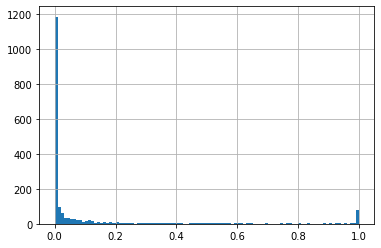

In [23]:
oof_df["pred"].hist(bins=100)